In [14]:
pip install tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


SyntaxError: invalid syntax (<ipython-input-13-776c25429cea>, line 1)

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column
from sklearn.metrics import multilabel_confusion_matrix, log_loss
tf.random.Generator = None  # Patch for a bug
import tensorflow_addons as tfa


from keras.models import Sequential
from keras.layers import Dense, Input
from pydoc import locate
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

Using TensorFlow backend.


In [17]:
table_features = []
table_labels = []
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
        table_features.append(value)
        print("{:20s}: {}".format(key,value.numpy()))
    for lab in label:
        table_labels.append(label)
        print(lab)

In [18]:
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  #labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [19]:
def _preprocess_line(features, targets):
    # Pack the result into a dictionary
    features = dict(zip(visu_data.columns, features))
    #print(features)
    features.pop('sig_id')
    features.pop('cp_time')
    #targets.pop('sig_id')
    targets = tf.stack(targets[1:])
    return features, targets


In [20]:
for dirname, _, filenames in os.walk('Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data\sample_submission.csv
Data\test_features.csv
Data\train_drug.csv
Data\train_features.csv
Data\train_targets_nonscored.csv
Data\train_targets_scored.csv


In [21]:
visu_data = pd.read_csv('./Data/train_features.csv')
visu_label = pd.read_csv('./Data/train_targets_scored.csv')
visu_data.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [22]:
X_train = pd.DataFrame(pd.read_csv('./Data/train_features.csv', nrows=5))
print(X_train.dtypes)
types = [str(), str(), str(), str()]
for i in range(4, len(X_train.dtypes)):
    if X_train.dtypes[i].kind == 'f':
        types.append(float())


sig_id      object
cp_type     object
cp_time      int64
cp_dose     object
g-0        float64
            ...   
c-95       float64
c-96       float64
c-97       float64
c-98       float64
c-99       float64
Length: 876, dtype: object


In [23]:
features = tf.data.experimental.CsvDataset('./Data/train_features.csv', record_defaults=types, header=True)

In [24]:
y = pd.DataFrame(pd.read_csv('./Data/train_targets_scored.csv', nrows=5))
types = ['']
for i in range(1, len(y.dtypes)):
    types.append(float())

In [25]:
targets = tf.data.experimental.CsvDataset('./Data/train_targets_scored.csv', record_defaults=types, header=True)

dataset = tf.data.Dataset.zip((features, targets))

In [26]:
dataset_size = dataset.reduce(np.int64(0), lambda x, _:x+1).numpy()
train_dataset = dataset.take(0.7*dataset_size)
val_dataset = dataset.skip(0.7*dataset_size)
val_dataset = dataset.take(dataset_size - 0.7*dataset_size)


In [27]:
train_dataset = train_dataset.map(_preprocess_line).batch(32)
val_dataset = val_dataset.map(_preprocess_line).batch(32)

In [28]:
all_columns = list(list(train_dataset.element_spec)[0].keys())
categorical_columns = [all_columns[0], all_columns[1]]
numerical_columns = all_columns[2:]
#numerical_columns.append(all_columns[1])


In [29]:
feature_columns = []

for col in categorical_columns:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(col, visu_data[col].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

In [30]:
for col in numerical_columns:
    feature_columns.append(feature_column.numeric_column(col))

In [31]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    feature_layer,
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    tfa.layers.WeightNormalization(layers.Dense(256, activation='relu')),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation='elu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    tfa.layers.WeightNormalization(layers.Dense(206, activation='softmax'))
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [33]:
history=model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=5)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/5
521/521 [==============================] - 149s 286ms/step - loss: 0.0199 - accuracy: 0.9968 - val_loss: 0.0170 - val_accuracy: 0.9969
Epoch 2/5
521/521 [==============================] - 114s 218ms/step - loss: 0.0175 - accuracy: 0.9969 - val_loss: 0.0161 - val_accuracy: 0.9970
Epoch 3/5
521/521 [==============================] - 115s 220ms/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.0155 - val_accuracy: 0.9970
Epoch 4/5
521/521 [==============================] - 115s 221ms/step - loss: 0.0160 - accuracy: 0.9970 - val_loss: 0.0149 - val_accuracy: 0.9971
Epoch 5/5
521/521 [==============================] - 114s 218ms/step - loss: 0.0156 - accuracy: 0.9970 - val_loss: 0.0145 - val_accuracy: 0.9971


In [34]:
show_batch(train_dataset)

cp_type             : [b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp']
cp_dose             : [b'D1' b'D1' b'D1' b'D1' b'D2' b'D1' b'D2' b'D1' b'D1' b'D2' b'D2' b'D2'
 b'D1' b'D2' b'D1' b'D1' b'D1' b'D2' b'D2' b'D1' b'D2' b'D1' b'D1' b'D1'
 b'D2' b'D1' b'D1' b'D2' b'D1' b'D1' b'D1' b'D2']
g-0                 : [ 1.062e+00  7.430e-02  6.280e-01 -5.138e-01 -3.254e-01 -6.111e-01
  2.044e+00  2.711e-01 -3.014e-01 -6.300e-02 -2.875e-01 -3.864e-01
  3.000e-03 -6.884e-01  4.242e-01  6.670e-02  8.738e+00 -4.764e-01
 -4.694e-01 -1.428e-01 -2.924e-01 -1.119e-01  6.111e-01 -1.850e-02
  4.442e-01 -6.696e-01 -2.740e-01 -2.156e-01  1.088e-01  5.497e-01
 -7.220e-02 -2.149e-01]
g-1                 : [ 0.5577  0.4087  0.5817 -

g-423               : [ 1.505e+00 -1.523e+00 -6.617e-01  6.760e-02  8.370e-02 -1.800e-03
  2.958e+00  5.211e-01  8.637e-01  6.423e-01  2.844e-01  1.199e+00
  1.066e+00 -2.123e+00 -7.827e-01 -1.138e+00 -7.706e+00 -1.831e-01
 -4.000e-03  2.247e-01  1.061e+00  9.800e-02  1.501e+00 -8.241e-01
  3.800e-03  3.835e-01 -8.874e-01 -2.463e-01  5.390e-01 -1.211e+00
 -4.130e-02  8.411e-01]
g-424               : [-6.908e-01 -6.122e-01  3.672e-01  1.376e+00  9.530e-01 -7.955e-01
 -2.597e+00  1.958e+00 -2.500e-03  1.093e+00  6.475e-01 -8.612e-01
 -8.782e-01 -4.017e-01  1.083e+00  2.667e-01  7.769e+00  1.290e-01
  2.050e-02 -8.038e-01  3.670e-02 -7.335e-01 -3.328e-01  3.160e-01
  8.820e-02 -4.971e-01  4.817e-01 -1.076e+00 -1.165e+00  1.181e-01
  4.177e-01  5.952e+00]
g-425               : [ 1.27    0.2376  1.611   0.0486  0.5553 -0.1445  0.224   1.247  -0.7319
  0.5518 -0.3609  0.5059 -0.8834  1.15    0.7692 -0.5146  3.438   2.62
  0.6311  1.082   0.3701 -0.5994  1.745  -1.172   0.3561 -0.7124  0.8989

g-769               : [ 1.649  -0.334   0.3143  0.4374 -0.7534  0.9579 -5.431   0.6872  0.7831
  0.6985 -0.9657  0.2333  0.1714 -0.719   1.735  -1.     -2.476   0.2403
 -0.0204 -0.6687  0.9348 -0.2751 -0.84    0.2219 -1.51   -0.5536  0.3252
  0.1135  1.099  -0.3069  0.9391  0.1887]
g-770               : [ 2.968e-01 -3.289e-01  8.133e-01  1.588e-01  5.000e-01  1.993e-01
  4.011e+00  6.410e-02 -4.754e-01 -8.000e-01 -5.023e-01  2.134e-01
  6.901e-01  3.300e-02 -8.297e-01 -1.052e+00 -6.988e+00 -9.944e-01
 -1.343e+00  3.615e-01  7.440e-01 -7.493e-01  6.406e-01  3.681e-01
  5.405e-01  9.114e-01 -7.923e-01 -6.364e-01 -2.900e-03 -1.124e+00
  1.188e+00 -2.740e-01]
g-771               : [-0.0224 -0.2718  0.7923 -0.0343 -0.6269  0.0592  2.534   1.328   0.0371
  0.7218 -1.22    0.0084  0.0727  0.7426  0.8997 -0.3691  3.107   1.326
  0.2313  0.317  -0.2128  0.0973 -0.2185 -1.26    0.0719 -0.2252  1.193
 -0.6115 -0.0328 -0.2102 -0.6715  0.0367]
c-0                 : [ -0.06     0.0927  -0.1312  -0.3

In [35]:
labels_val = visu_label[int(0.7*dataset_size)+1::]
labels_val = labels_val.drop(['sig_id'], axis=1)
result_prediction = model.predict(val_dataset)

In [36]:
bool_res = []
for row in result_prediction:
    for col in row:
        bool_res.append(col == max(row))

print(sum(multilabel_confusion_matrix((labels_val > 0), np.asarray(bool_res).reshape(7144, 206))))

[[1459551    7027]
 [   4969     117]]


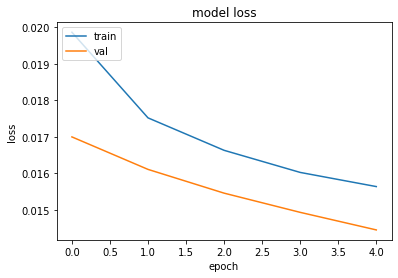

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

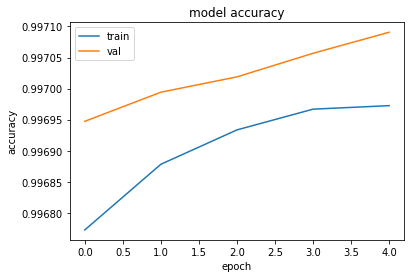

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
def metric(y_true, y_pred):
    metrics = []
    for i in range(y_pred.shape[1]):
        if y_true[:, i].sum() > 1:
            metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float)))
    return np.mean(metrics)

print(f'OOF Metric: {metric(np.asarray(labels_val), np.asarray(result_prediction))}')

OOF Metric: 0.030562673395046386
